# Time Series Forecasting with XGBoost



In this project we will be doing time series forecasting with XGBoost. We will be using the [Air Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Air+Quality) from the UCI Machine Learning Repository. The dataset contains hourly air quality measurements from an Italian city. We will be using the data from March 2004 to April 2005. The dataset contains 9358 instances and 15 attributes. The goal of this project is to predict the next hour's NOx(GT) level.




In [2]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')    # This is a style of plot



## Step 0. Read in Data

In [3]:
df = pd.read_csv('airQualityUCI.csv')

In [9]:
df = pd.read_excel('AirQualityUCI.xlsx')
df.shape

The data has 9357 rows and 15 columns. The columns are:


In [11]:
df.columns.to_list()

['Date',
 'Time',
 'CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         9357 non-null   float64       
 1   PT08.S1(CO)    9357 non-null   float64       
 2   NMHC(GT)       9357 non-null   int64         
 3   C6H6(GT)       9357 non-null   float64       
 4   PT08.S2(NMHC)  9357 non-null   float64       
 5   NOx(GT)        9357 non-null   float64       
 6   PT08.S3(NOx)   9357 non-null   float64       
 7   NO2(GT)        9357 non-null   float64       
 8   PT08.S4(NO2)   9357 non-null   float64       
 9   PT08.S5(O3)    9357 non-null   float64       
 10  T              9357 non-null   float64       
 11  RH             9357 non-null   float64       
 12  AH             9357 non-null   float64       
 13  Datetime       9357 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 1023.5 KB


In [17]:
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,2004-03-10 18:00:00
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,2004-03-10 19:00:00
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,2004-03-10 20:00:00
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,2004-03-10 21:00:00
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,2004-03-10 22:00:00


## Step 0. Data Preprocessing

We will first merge the date and time columns into a single column


In [15]:
# Convert the 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Combine the 'Date' and 'Time' columns
df['Datetime'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'].astype(str))

# Drop the original 'Date' and 'Time' columns if not needed
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Now you have a new 'Datetime' column that contains the merged datetime values
print(df['Datetime'])

0      2004-03-10 18:00:00
1      2004-03-10 19:00:00
2      2004-03-10 20:00:00
3      2004-03-10 21:00:00
4      2004-03-10 22:00:00
               ...        
9352   2005-04-04 10:00:00
9353   2005-04-04 11:00:00
9354   2005-04-04 12:00:00
9355   2005-04-04 13:00:00
9356   2005-04-04 14:00:00
Name: Datetime, Length: 9357, dtype: datetime64[ns]


We see from the head and tail functions that the data is in hourly format, from 2004-03-10 to 2005-04-04. We will now set the  datetime object as the index.

In [18]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index) #The dataframe index is an object, we need to convert it to a datetime object.

Since the value -200 was inserted in place of the missing values, we need to count them to determine the amount of missing values.

In [35]:
# Count occurrences of -200 for each variable
missing_value_counts = (df == -200).sum()

# Display the counts
print(missing_value_counts)

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


Since NMHC(GT), Non Metanic Hydrocarbons Ground Truth, is missing 8443 of the total 9357 recprds, we will drop this variable from the dataset.

In [23]:
df.drop('NMHC(GT)', axis=1, inplace=True) # Drop the 'NMHC(GT)' column


Nine of the variable each have 366 missing values. Let's check if these all occur on same day or datetime

In [32]:
# Select variables with 366 missing values
variables_with_366_missing = df.columns[(df == -200).sum() == 366]

# Filter the DataFrame for these variables
filtered_df = df[variables_with_366_missing]

# Check if all missing values occur on the same datetime
same_datetime = filtered_df.index.nunique() == 1

print(same_datetime)



False


The variables with 366 missing values do not occur on the same datetime.  This suggests that the missing values are distributed across different timestamps.
  
We will handle the missing values by using forward filling, using the fillna() method.

In [34]:
# Replace -200 with NaN
df = df.replace(-200, np.nan)

# Impute missing values
df_imputed = df.fillna(method='ffill')  # Replace with forward fill (or any other imputation method)
df = df_imputed



## Step 1. EDA

Lets plot this to visualize what we are working with.

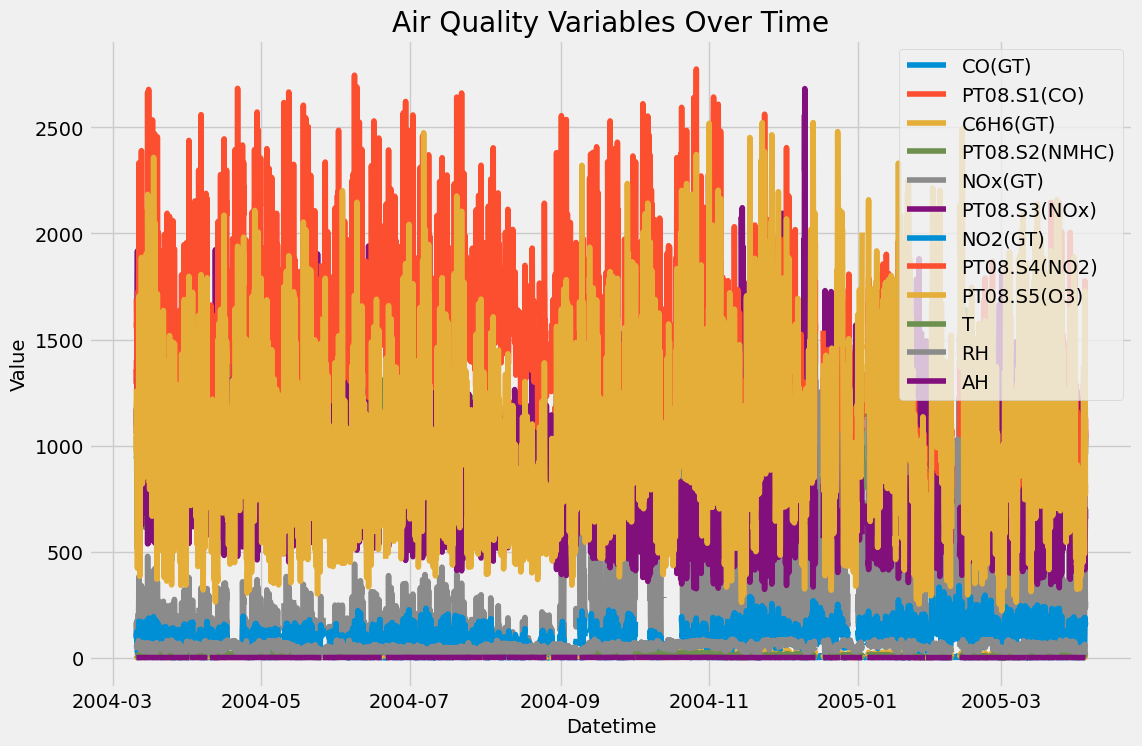

In [36]:
# Create a figure and axes for subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Loop through each variable
for variable in df.columns:
    # Exclude the Datetime column
    if variable != 'Datetime':
        # Plot the variable on the axes
        ax.plot(df.index, df[variable], label=variable)

# Set the title, x-axis label, and y-axis label
ax.set_title('Air Quality Variables Over Time')
ax.set_xlabel('Datetime')
ax.set_ylabel('Value')

# Add a legend to differentiate the variables
ax.legend()

# Show the plot
plt.show()


Next, lets look at the correlations between the variables

This will calculate the correlation coefficient between each pair of variables in the DataFrame df. The resulting correlation_matrix will be a new DataFrame that contains the correlation values.

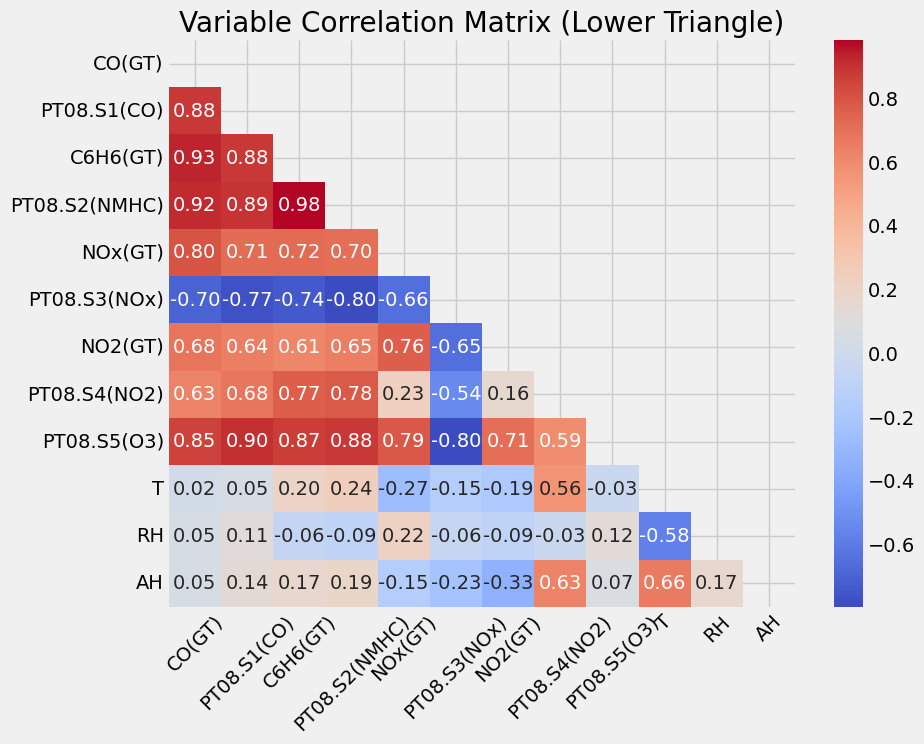

In [43]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create correlation matrix plot
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title("Variable Correlation Matrix (Lower Triangle)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


 Correlation coefficients range from -1 to 1, where values close to -1 indicate a strong negative correlation, values close to 1 indicate a strong positive correlation, and values close to 0 indicate a weak or no correlation.

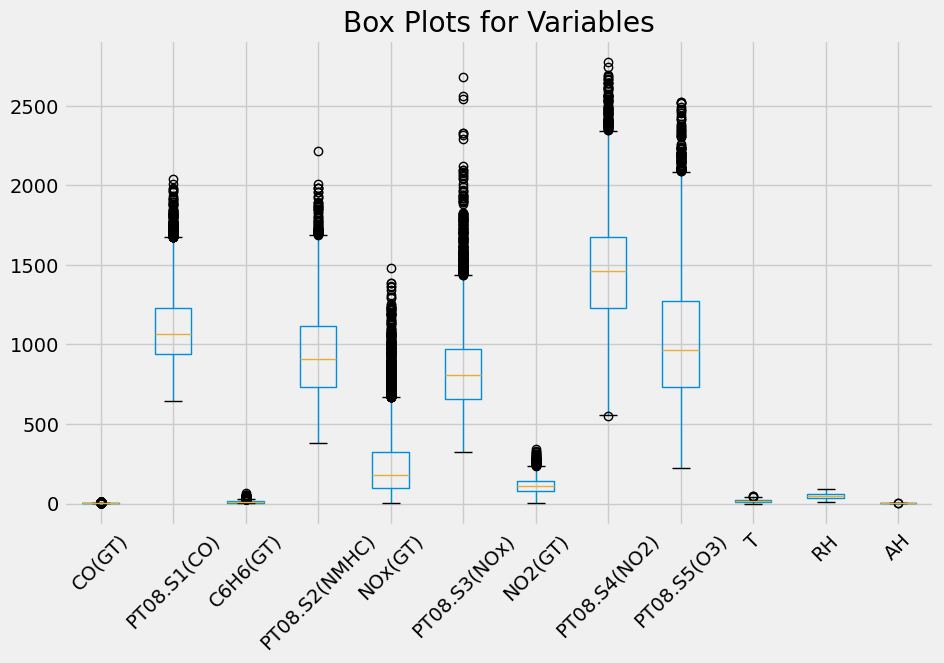

In [48]:
# Create box plots for each variable
plt.figure(figsize=(10, 6))
df.boxplot(column=list(df.columns))
plt.title('Box Plots for Variables')
plt.xticks(rotation=45)
plt.show()



When you see circles above and outside the upper whisker in a box plot, they represent outliers in the data. Outliers are data points that significantly deviate from the rest of the distribution and can potentially indicate unusual or extreme values.     Data Quality: Outliers may indicate errors or data quality issues. It's important to investigate these points further to determine if they are genuine data points or errors in data collection or recording.
  
Additionally;
  
    Extreme Values: Outliers could represent extreme values that occur naturally in the data. These extreme values may be valid observations and could provide valuable insights or indicate exceptional conditions.

    Skewed Distribution: Outliers may suggest that the underlying distribution of the variable is skewed or has heavy tails. This can be relevant for understanding the data and selecting appropriate statistical methods or models for analysis.

    Anomalies or Events: Outliers might indicate rare events or anomalies in the data. Depending on the domain or application, these outliers could represent important events or situations that require further investigation or consideration.

## Step 2. Feature Engineering

## Step 3. Train/Test Split

In [8]:
df.shape

(145366, 1)

We are going to split the data on the date January, 2015. The reason for this is that we want to train our model on data before this date and test our model on data after this date. This is a common practice in time series modeling.            

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

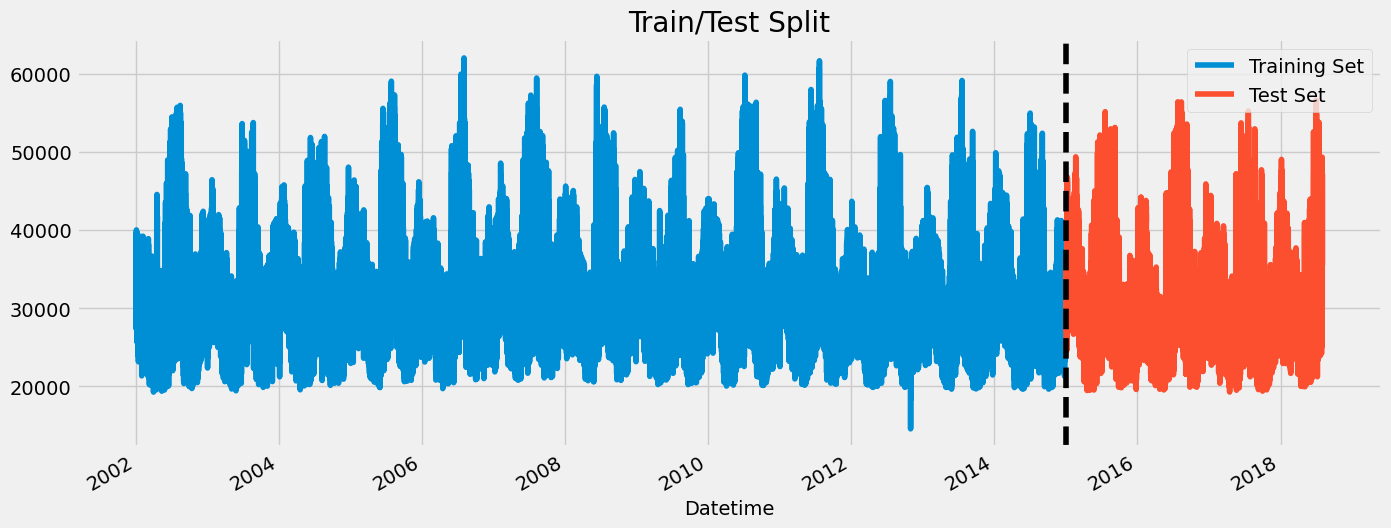

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.axvline(pd.to_datetime('01/01/2015'), color='k', linestyle='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Train/Test Split')
plt.show()

Next, lets get an idea of what one single week looks like in the data. We can see that there is a clear trend and seasonality to the data. The trend is that the power consumption is increasing over time, and the seasonality is that there is a yearly pattern to the power consumption. 

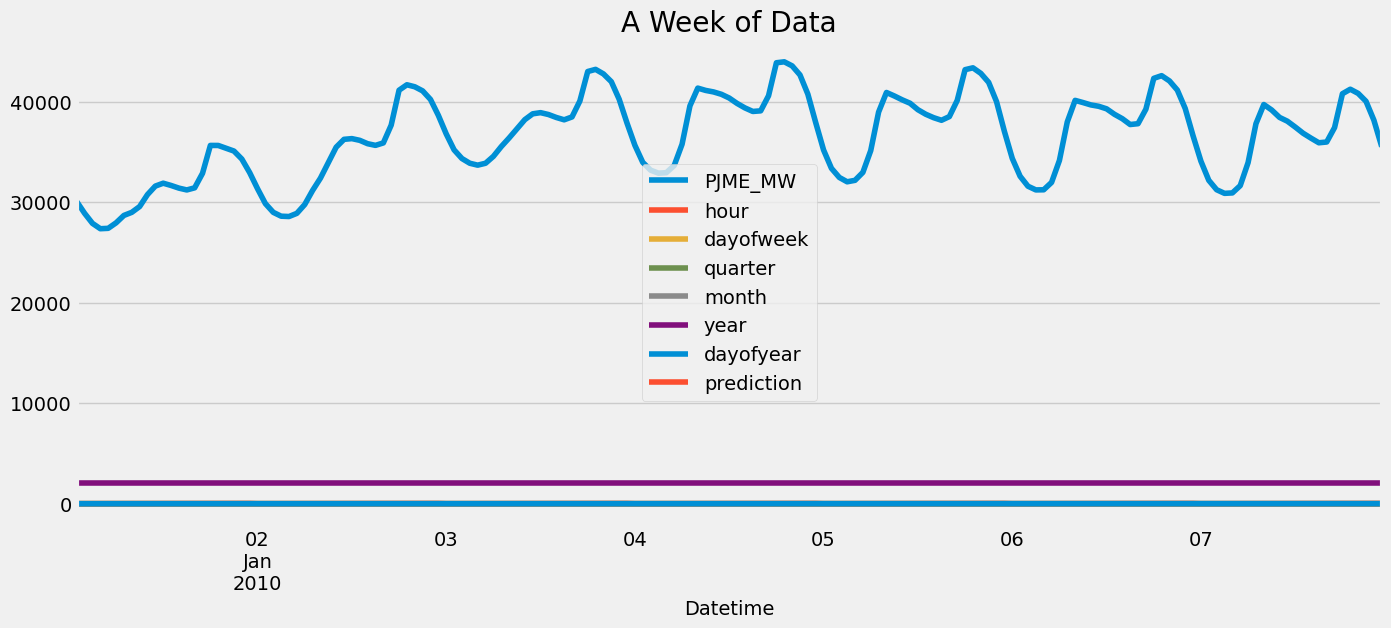

In [41]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 6), title='A Week of Data')
plt.show()

We can notice a few things here;
* Within each day, there are 2 different peaks. This is fairly common in energy consumption.
* There also appears to be valleys during the nights
* A weekend/holiday effect seems to be taking place as well with lower overall consumption.

## Feature Engineering


We can use pandas .hour attribute to get the hour of the day for each index. We can also use other attributes to pull additional data from the index.  To make this cleaner, will create a function called features for our engineering.
   
We will add these as new columns to our dataframe.


In [12]:

def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy() # We don't want to modify the original dataframe
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # Monday=0, Sunday=6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

In [13]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


## Visualizing the Feature / Target Relationship

Text(0.5, 1.0, 'Hourly Boxplot of Energy Consumption (in MWh)')

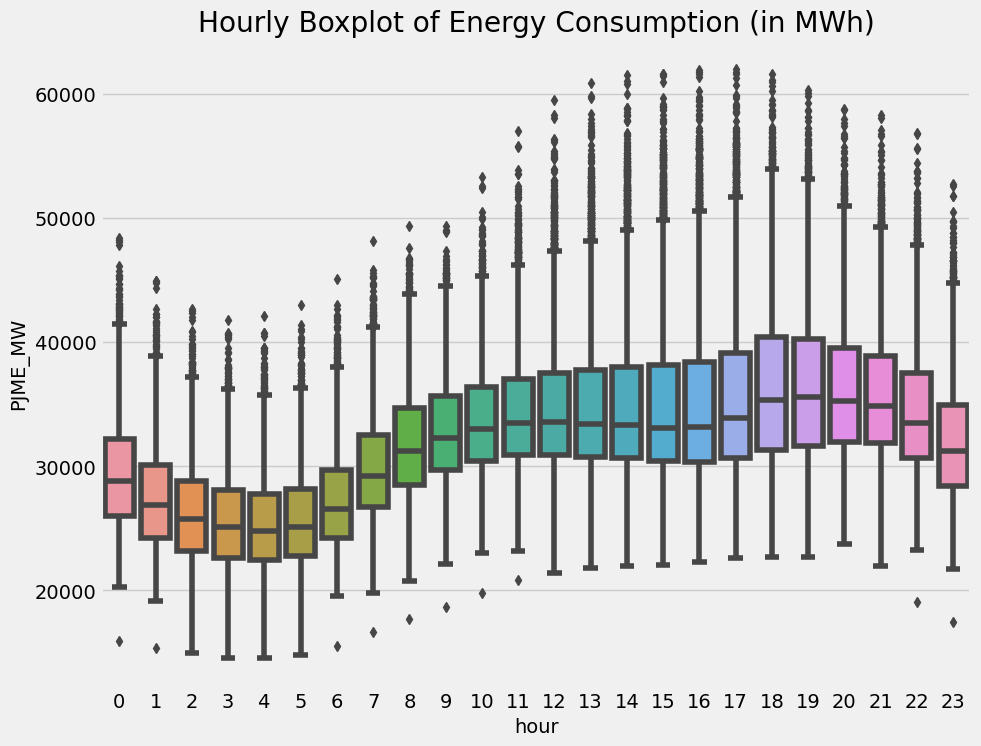

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df, x='hour', y='PJME_MW')
ax.set_title('Hourly Boxplot of Energy Consumption (in MWh)')    # This is a style of plot

We see that early in the morning, there appears to be a dip in energy usage until 5.  It tends to get higher in the evening.

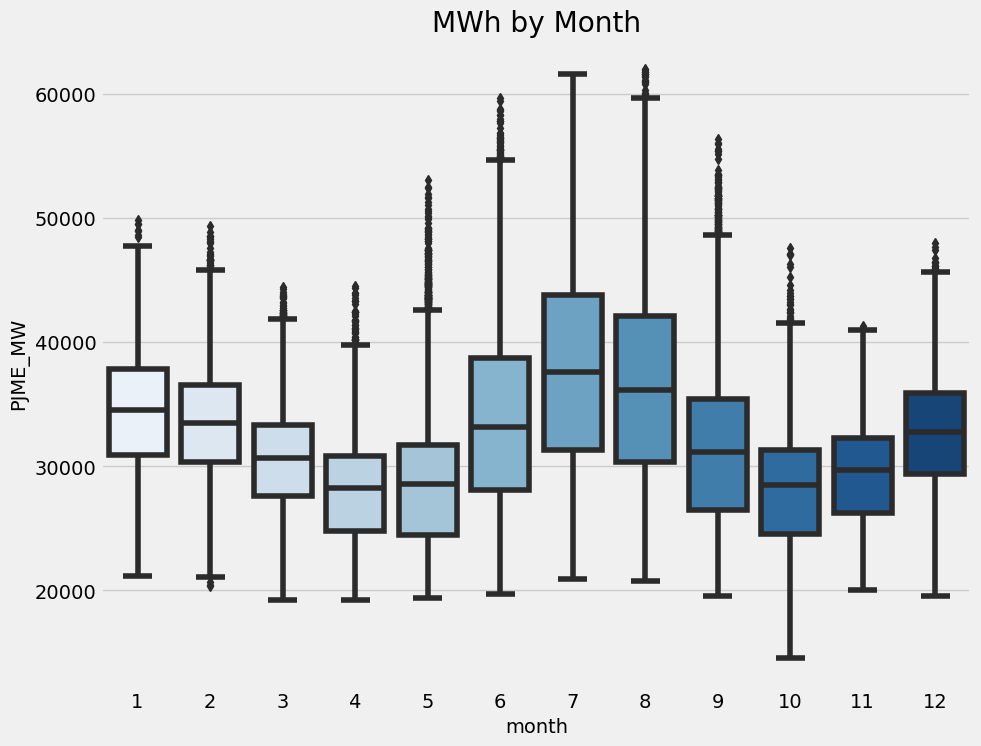

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MWh by Month') 
plt.show()

The MW usage by month tends to peak two times, in the winter season and again in the Summer

## Model Creation
  
  This model will be created on the training data and evaluated on the test data set.

In [16]:
# We need to run the training and testing data through the same features function
train = create_features(train)
test = create_features(test)

In [17]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [18]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [19]:
# we need to drop the target values from the training and testing datasets
# X_train = train.drop('PJME_MW', axis=1) # axis=1 means we are dropping a column instead of a row
# y_train = train['PJME_MW']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]  



In [20]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01) 
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50, # Activates early stopping. The model will train until the validation score stops improving.
        verbose=100) # If 'verbose' and an evaluation set is used, writes the evaluation metric measured on the validation set to stderr.

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935


[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[450]	validation_0-rmse:2771.93085	validation_1-rmse:3730.77469


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

The output shows that RMSE goes down through each iteration on the training set. However, the validation on the test set starts to go down but then begins to get worse after 10 iterations.
  
  This is indicative of overfitting with n_estimators=1000.  Another thing we can do is lower the learning rate.

With a learning rate of 0.01, and verbose set to show every 100 trees built.  This stopped at 450 trees because our test or validation set started to get worse after that many trees were built.

## Feature Importance
This will give us the importance values based on how much these features were used in each of the trees built by the XGBoost model.



In [25]:
# This is a list of the importance of each feature 
fi = pd.DataFrame(data=reg.feature_importances_,
             index= reg.feature_names_in_,
             columns=['importance'])


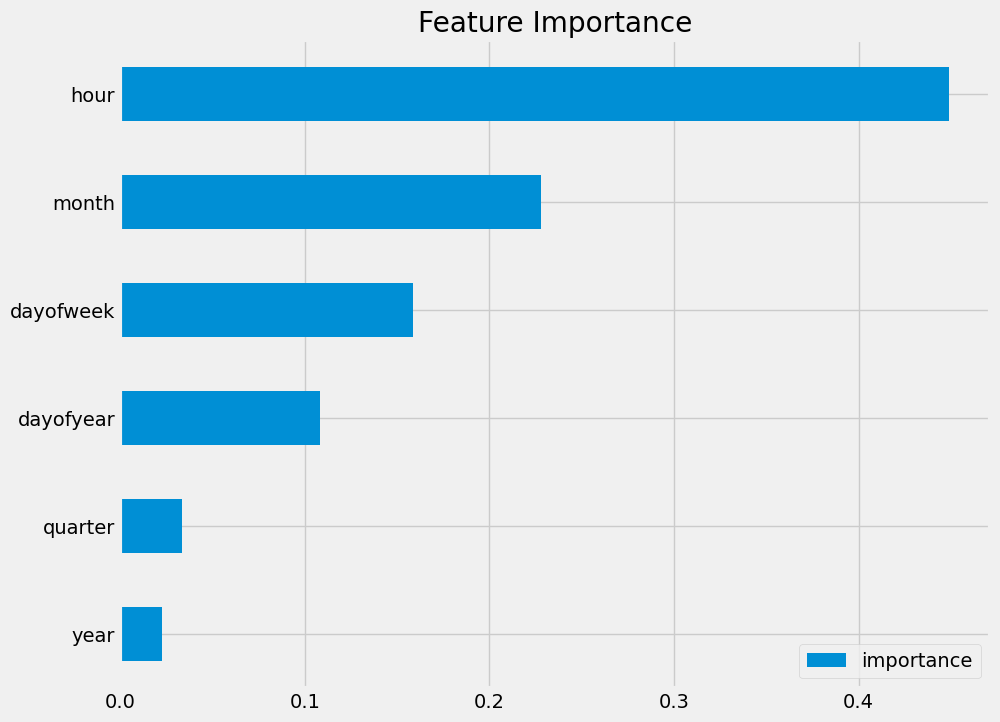

In [29]:
fi.sort_values(by='importance', ascending=True).plot(kind='barh', 
                                                      title='Feature Importance',
                                                      figsize=(10, 8)) 
plt.show()

Keep in mind that when you have highly correlated features, this feature importance functionality will not tell you exactly how important each feature is individually.

##  Forecast on Test


In [32]:
test['prediction'] = reg.predict(X_test)

Now I would like to see these predictions next to all the training data, so we will merge this.

In [38]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

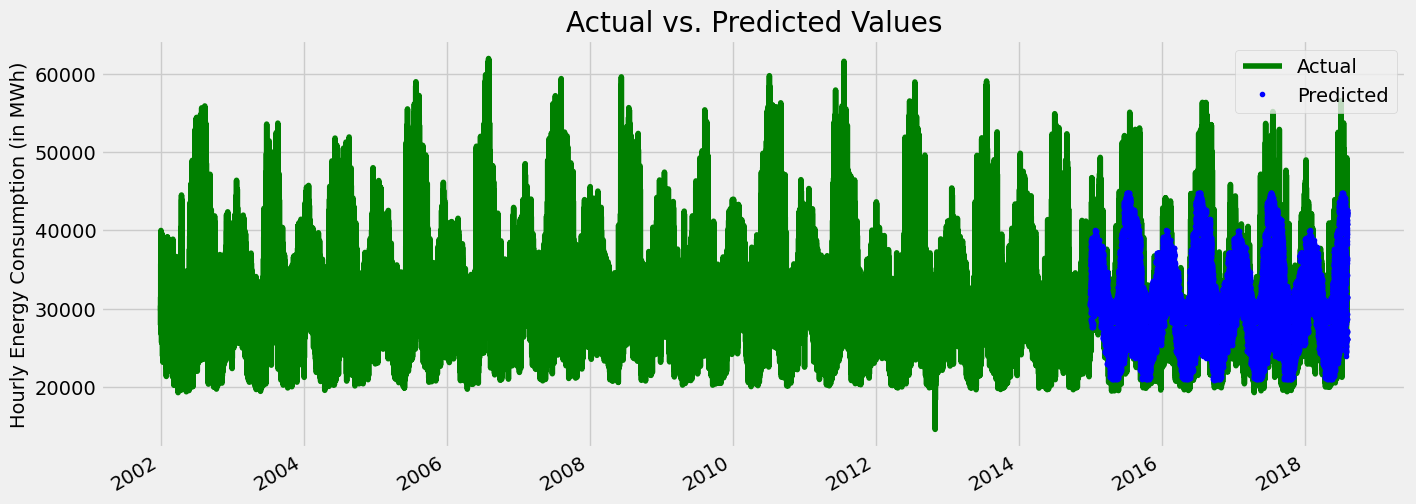

In [62]:
ax = df[['PJME_MW']].plot(figsize=(15, 6), color='green')
df['prediction'].plot(ax=ax, style='.', color = 'blue')
ax.set_title('Actual vs. Predicted Values')
ax.legend(['Actual', 'Predicted'])
ax.set_ylabel('Hourly Energy Consumption (in MWh)')
ax.set_xlabel('')
plt.show()


Similar to what was done previously, lets look at one week of data to see how the model performed.

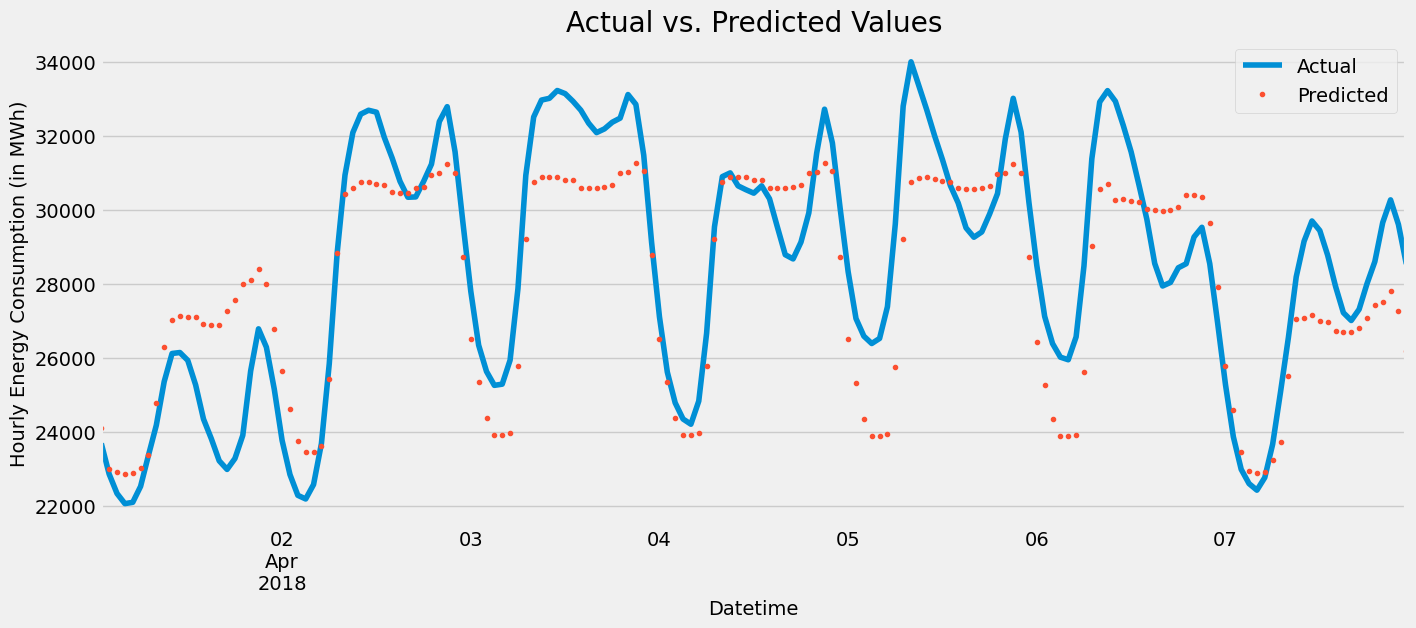

In [42]:

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 6), title='A Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
ax.set_title('Actual vs. Predicted Values')
ax.legend(['Actual', 'Predicted'])
ax.set_ylabel('Hourly Energy Consumption (in MWh)')
plt.show()

We can see that the model isnt perfect. There is room for improvement. For example, this could include better parameter tuning.  Also, we could add in features for specific days of the year, like holidays.
    
The predictions do generally follow the trend you would expect to see with the peaks and valleys.

Lastly, we will run the evaluation metric on this

In [49]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction'])) # RMSE
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3715.93


### Calculate Error
* Look at the worst and best predicted days

In [50]:
test['error'] = np.abs(test[TARGET] -test['prediction'])

In [51]:
test['date'] = test.index.date

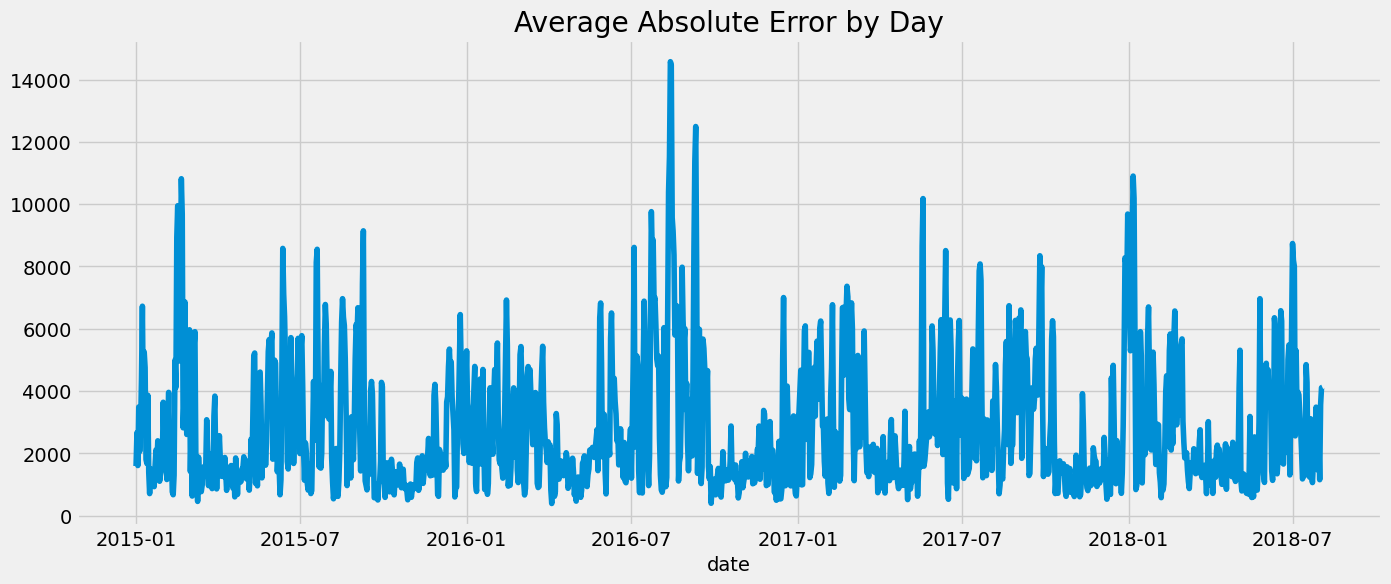

In [52]:
test.groupby('date')['error'].mean().plot(figsize=(15, 6),  
                                            title='Average Absolute Error by Day')
plt.show()

In [56]:
test.groupby('date')['error'].mean().sort_values().head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

Some of the best predictions were on days with the lowest average absolute error. These seem to be in 2016. 
  
  Next, Let's take a look at the worst days.

In [57]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

The worst predicted days all seem to be in the middle of August in 2016

### Next Steps:
- More robust cross-validation
- Add more features (i.e. Weather forecasts, holidays)

# The End

Using XGBoost for time series forecasting is a valid approach and can potentially yield good results. XGBoost is a powerful gradient boosting algorithm that can handle complex patterns and dependencies in the data.

To use XGBoost for time series forecasting on the air quality dataset, here's a general outline of the steps involved:

    Data Preprocessing: Clean the dataset, handle missing values, and convert the relevant columns to appropriate data types.

    Feature Engineering: Extract relevant features from the dataset that can capture the patterns and dependencies in the time series. This can include lagged variables, rolling statistics, or any domain-specific features.

    Train-Test Split: Split the dataset into training and testing sets. Typically, you would use a majority of the data for training and reserve a portion for model evaluation.

    Prepare Data for XGBoost: Transform the data into a format suitable for XGBoost. This may involve converting the time series data into a supervised learning problem by creating input-output pairs.

    Model Training: Fit an XGBoost model to the training data. Tune the hyperparameters of the model, such as learning rate, maximum depth, and number of estimators, using techniques like cross-validation or grid search.

    Model Evaluation: Evaluate the performance of the XGBoost model on the testing set using appropriate evaluation metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), or others.

    Forecasting: Use the trained XGBoost model to forecast future values of the air quality based on the available data.

    Visualization: Visualize the forecasted values alongside the actual values to assess the model's accuracy and understand the predicted trends.

It's important to note that time series forecasting with XGBoost may require additional considerations, such as handling time-dependent features, incorporating external variables if available, and addressing potential issues like overfitting or model interpretation.

Additionally, you may explore advanced time series forecasting techniques specific to XGBoost, such as using lagged variables as features, handling seasonality, or incorporating time-related features into the model.